In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import sys
sys.path.append("..")

from scripts.plot_style import *
stdrcparams(usetex=True) # personal plot style
figsize=stdfigsize(ratio=-1)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from time import time
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

from joblib import Parallel, delayed
import multiprocessing

import umap

In [12]:
from matplotlib.colors import ListedColormap
colormap = [
        "#1f77b4",
     "#ff7f0e",
"#2ca02c",
"#d62728",
"#9467bd",
"#8c564b",
"#e377c2",
"#7f7f7f",
"#bcbd22",
"#17becf"
        ]

In [47]:
df = pd.read_csv('../data/pbmc_final.csv',header=0,index_col=0)
df.head().T

,AACACACTCGACGAGA,AACAGGGCAGGAGGTT,AACAGGGCAGTGTATC,AAGACTCTCGACCACG,AAGATAGCAGGCATGA
CD14,824,1148,2452,2517,7650
CD19,1,0,5,4,2063
AL627309.1,0,0,0,0,0
FAM87B,0,0,0,0,0
FAM41C,0,0,0,0,0
...,...,...,...,...,...
MAFIP,0,0,0,0,0
AC011043.1,0,0,0,0,0
AL592183.1,0,0,0,0,0
AC007325.4,0,0,0,0,0


In [48]:
X = df.loc[:, df.columns != 'label']
X = X.applymap(lambda x: np.log(1+x))
X['label'] = df['label']

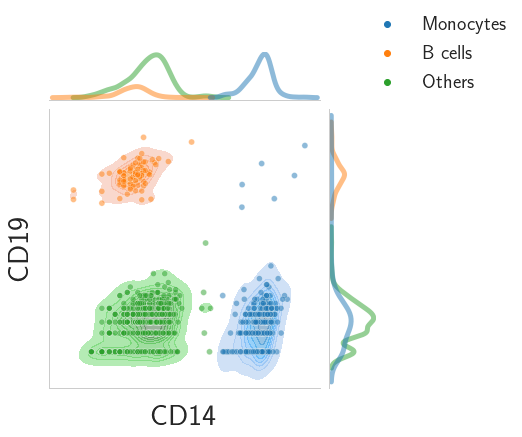

In [54]:
g = sns.jointplot(
    data=X,
    x="CD14", y="CD19", hue="label",palette=colormap[0:3],
    kind="kde",marginal_kws={"color":"r", "alpha":.5}, shade=True, shade_lowest=False, alpha=.5, legend_out=True)
sns.scatterplot( data=X,x="CD14", y="CD19", hue="label",palette=colormap[0:3],ax=g.ax_joint,alpha=0.5)
sns.move_legend(g.ax_joint, "lower right", bbox_to_anchor=(1.76, 1), title='',frameon=False)
g.ax_marg_x.set_xticks([])
g.ax_marg_y.set_yticks([])
texts = g.ax_joint.legend_.texts
for t, label in zip(texts, ["Monocytes","B cells",  "Others"]):
    t.set_text(label)
plt.show()

In [17]:
# use UMAP for dimension reduction & apply RF
cv_scores_list = []
out = {}
# n_noisy_list = [0,2,10,20,30,40,50,60,70,80,90,100,1000,5000,8000]
n_noisy_list = [0,2,20,100,1000,8000]
for n_noisy in n_noisy_list:
    FileName = '../cell_data/pbmc_final.csv'
    use_columns = [1,2] + [i+3 for i in range(n_noisy)] + [8407]
    columns = ['signal1', 'signal2'] + ['noisy'+str(i+3) for i in range(n_noisy)] + ['label']
    df = pd.read_csv(FileName,
                header=0,
                usecols=use_columns,
                names=columns)
    X, y = df.loc[:, df.columns != 'label'].to_numpy(),df.label.to_numpy()
    X = np.log(X + 1)
    n_components = 2 #the dimension 
    method = umap.UMAP()
    label = df['label'] # the class/cluster (y) -- want to assign the data points to (1 or 2 in this problem)
    Y = method.fit_transform(X)
    out[n_noisy]=(Y.copy(), y)
    clf = BaggingClassifier()
    Y_train, Y_test, y_train, y_test = train_test_split(Y,y)
    clf.fit(Y_train,y_train)

In [61]:
import warnings
from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend
from sklearn.metrics import accuracy_score
def plot_decision_boundary2D(n_clusters: int, method:str, label: str,acc:float, clf, X: np.ndarray, y: np.ndarray, classes: list, colormap: np.ndarray,
                             step: float = 0.1, prob_dot_scale: int = 40, prob_dot_scale_power: int = 3,
                             true_dot_size: int = 50, pad: float = 1,
                             prob_values: list = [0.4, 0.6, 0.8, 1.0]) -> None:
    """
    Original work by @timothyvh on Twitter.
    Recreating an R ggplot decision boundary plotting in python using matplotlib. 
    Note that this only works for 2D plotting. The goal of this function is to present a 
    classifier's decision boundary in an easy to read, digestible way to ease
    communication and visualization of results. 
    
    Arguments:
    clf - the classifier we want to visualize the decision boundary for. This should work for any kind of relevant model.
    X - our data we want to plot. Note that since this is a 2D array, X should be 2-dimensional.
    y - the target labels for the data we want to plot
    classes - the names of the classes you are trying to identify, should be same shape as colormap
    colormap - the colors you want to use to indicate your different classes, should be same shape as classes
    step - mesh stepsize
    prob_dot_scale - modifier to scale the probability dots
    prob_dot_scale_power - exponential used to increase/decrease size of prob dots
    true_dot_size - size of the true labels
    pad - how much to "pad" around the true labels
    prob_values - list of probabilities to map the meshgrid predictions to

    Returns:
    None - This function will simply output a graph of the decision boundary
    """
   # Handling X data dimension issues. If X doesn't have enough dimensions, throw error. Too many, use first two dimensions.
    X_dim = X.shape[1]
    if X_dim < 2:
        raise Exception("Error: Not enough dimensions in input data. Data must be at least 2-dimensional.")
    elif X_dim > 2: 
        warnings.warn(f"Warning: input data was {X_dim} dimensional. Expected 2. Using first 2 dimensions provided.")
    
    # Change colormap to a numpy array if it isn't already (necessary to prevent scalar error)
    if not isinstance(colormap, np.ndarray):
        colormap = np.array(colormap)        
    y = y.astype(int) - 1 
    # create the x0, x1 feature. This is only a 2D plot after all. 
    x0 = X[:,0]
    x1 = X[:,1]
    
    # create 1D arrays representing the range of probability data points
    x0_min, x0_max = np.round(x0.min())-pad, np.round(x0.max()+pad)
    x1_min, x1_max = np.round(x1.min())-pad, np.round(x1.max()+pad) 
    step0 = (x0_max-x0_min)/70
    step1 = (x1_max-x1_min)/70
    x0_axis_range = np.arange(x0_min,x0_max, step0)
    x1_axis_range = np.arange(x1_min,x1_max, step1)
    
    # create meshgrid between the two axis ranges
    xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)
    
    # put the xx in the same dimensional format as the original X
    xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
    
    yy_hat = clf.predict(xx).astype(int)#-1 # prediction of all the little dots
    yy_prob = clf.predict_proba(xx) # probability of each dot being 
                                    # the predicted color
    yy_size = np.max(yy_prob, axis=1)
    
    # make figure
    plt.style.use('seaborn-whitegrid') # set style because it looks nice
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
    # plot all the little dots
    ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.3, s=prob_dot_scale*yy_size**prob_dot_scale_power,
#                label= f"Uninf.: {label} \n RLP: {acc}\%", 
               linewidths=0,)
#     plt.title(f"Uninf.: {label}, RLP: {acc}\%",)
    # plot the contours
    ax.contour(x0_axis_range, x1_axis_range, 
               np.reshape(yy_hat,(xx0.shape[0],-1)), 
               levels=3, linewidths=1, 
               colors=[colormap[0], colormap[1], colormap[1]])
 
    # plot the original x values.
#     ax.scatter(x0, x1, c=colormap[y], s=true_dot_size, zorder=3, linewidths=0.7, edgecolor='k')
    y_pred = clf.predict(X).astype(int)-1
    cc = ['white' if y[i]==y_pred[i] else colormap[y[i]] for i in range(len(y))]
    # plot the original x values.
    ax.scatter(x0, x1, c=cc, s=true_dot_size, zorder=3, linewidths=0.7, edgecolor='k')
 
    # create legends - Not sure if these serve a purpose but I left them in just in case
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
 
    ax.set_ylabel(r"$x_1$")
    ax.set_xlabel(r"$x_0$")
 
    ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
    ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)
 
    # only use integers for axis tick labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
 
    # remove first ticks from axis labels, for looks
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])
    custom_frame(ax)
#     plt.legend(box, frameon=False,loc='lower right' )
#     plt.xlabel(f"{method}1")
#     plt.ylabel(f"{method}2")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])
    fig.text(0.85, 0.18,f"L = {acc}\%",fontsize=20, fontweight='bold', ha="right", va="bottom",bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))
    plt.savefig(f'../Figs_CELL/C{n_clusters}_{method}_{n_noisy}.png',bbox_inches='tight',transparent=True)
    plt.show()

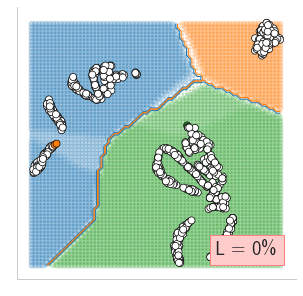

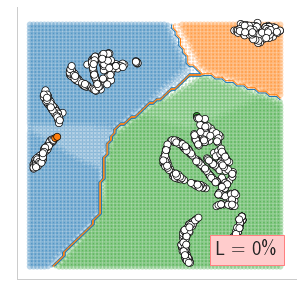

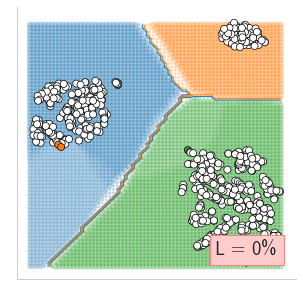

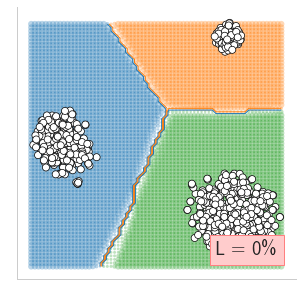

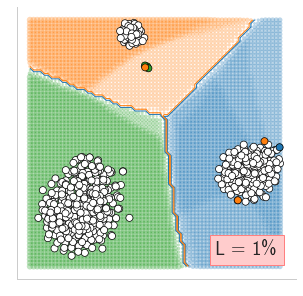

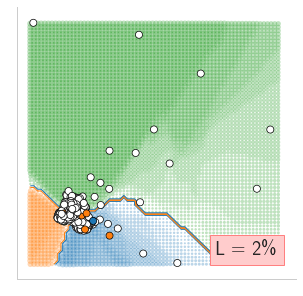

In [62]:
from sklearn import neighbors
N_NEIGHBORS = 15 # KNN number of neighbors
H = 0.1 # mesh stepsize
PROB_DOT_SCALE = 40 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 50 # size of the true labels
PAD = 1.0 # how much to "pad" around the true labels

# establish colors and colormap
redish = '#d73027'

orangeish = '#fc8d59'
blueish = '#4575b4'
colormap = [
        "#1f77b4",
     "#ff7f0e",
"#2ca02c",
"#d62728",
"#9467bd",
"#8c564b",
"#e377c2",
"#7f7f7f",
"#bcbd22",
"#17becf"
        ][0:3]

#establish classes
classes = ['0','1',"2"]

for n_noisy, (x, y) in out.items():
    # load data again

    clf = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
    clf.fit(x, y)
    acc = accuracy_score(y, clf.predict(x))

    # use function
    plot_decision_boundary2D(3,"UMAP",f"{n_noisy}", str(int(100*(0.999925-acc)/(0.999925-1/3))), clf, x, y.copy(), classes, colormap, 
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,)

In [20]:
# Apply RF to data after dimension reduction by t-SNE (n_iters=2000)

# dimension reduction of original data by t-SNE
cv_scores_list = []
out_pca = {}
n_noisy_list = [0,2,10,20,30,40,50,60,70,80,90,100,1000,5000,8000]
n_noisy_list = [0,2,20,100,1000,8000]
for n_noisy in n_noisy_list:
    FileName = '../cell_data/pbmc_final.csv'
    use_columns = [1,2] + [i+3 for i in range(n_noisy)] + [8407]
    columns = ['signal1', 'signal2'] + ['noisy'+str(i+3) for i in range(n_noisy)] + ['label']
    df = pd.read_csv(FileName,
                header=0,
                usecols=use_columns,
                names=columns)
    X, y = df.loc[:, df.columns != 'label'].to_numpy(),df.label.to_numpy()
    X = np.log(X + 1)
    n_components = 2 #the dimension
    method = PCA(n_components= n_components)
    
    label = df['label'] # the class/cluster (y) -- want to assign the data points to (1 or 2 in this problem)
    Y = method.fit_transform(X)
    out_pca[n_noisy]=(Y.copy(), y)
   

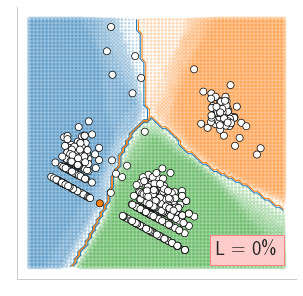

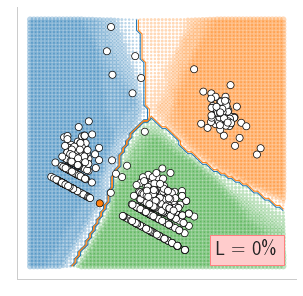

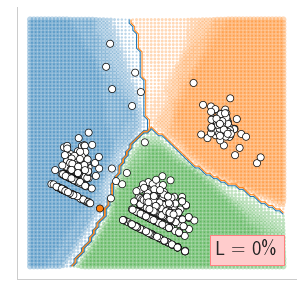

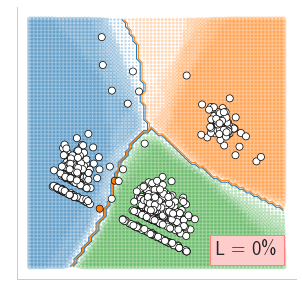

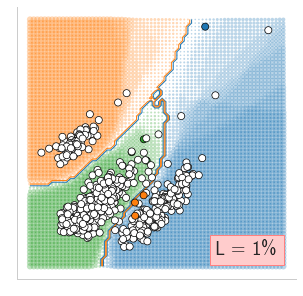

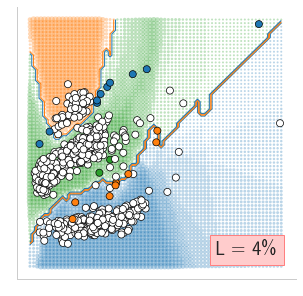

In [63]:
for n_noisy, (x, y) in out_pca.items():
    # load data again

    clf = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
    clf.fit(x, y)
    acc = accuracy_score(y, clf.predict(x))

    # use function
    plot_decision_boundary2D(3,"PCA",f"{n_noisy}", str(int(100*(0.999925-acc)/(0.999925-1/3))), clf, x, y.copy(), classes, colormap,  
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,)

In [23]:
# Apply RF to data after dimension reduction by t-SNE (n_iters=2000)

print('RF Accuracy for Different Number of Noisies after Dimension Reduction by t-SNE (n_iters=2000)')
# dimension reduction of original data by t-SNE
cv_scores_list = []
out = {}
n_noisy_list = [0,2,10,20,30,40,50,60,70,80,90,100,1000,5000,8000]
n_noisy_list = [0,2,20,100,1000,8000]
for n_noisy in n_noisy_list:
    FileName = '../cell_data/pbmc_final.csv'
    use_columns = [1,2] + [i+3 for i in range(n_noisy)] + [8407]
    columns = ['signal1', 'signal2'] + ['noisy'+str(i+3) for i in range(n_noisy)] + ['label']
    df = pd.read_csv(FileName,
                header=0,
                usecols=use_columns,
                names=columns)
    X, y = df.loc[:, df.columns != 'label'].to_numpy(),df.label.to_numpy()
    X = np.log(X + 1)
    n_components = 2 #the dimension
    method = manifold.TSNE(n_components= n_components, n_iter=2000, init='pca',
                                 random_state=0)
    
    label = df['label'] # the class/cluster (y) -- want to assign the data points to (1 or 2 in this problem)
    Y = method.fit_transform(X)
    out[n_noisy]=(Y.copy(), y)
   

RF Accuracy for Different Number of Noisies after Dimension Reduction by t-SNE (n_iters=2000)


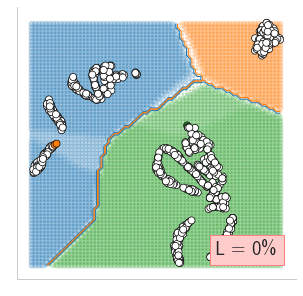

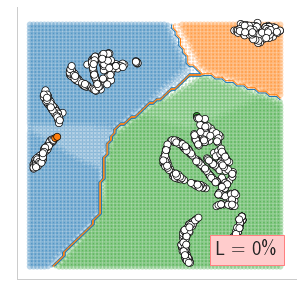

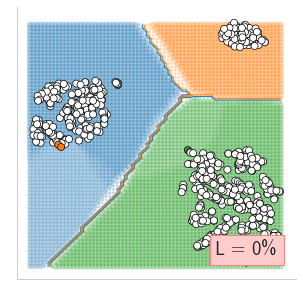

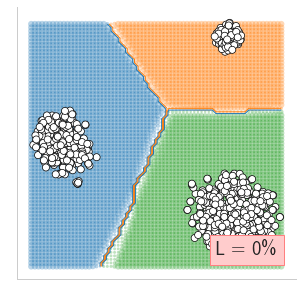

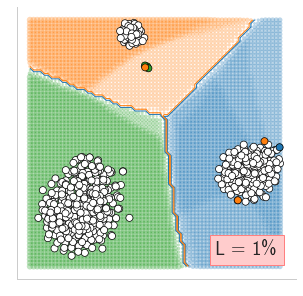

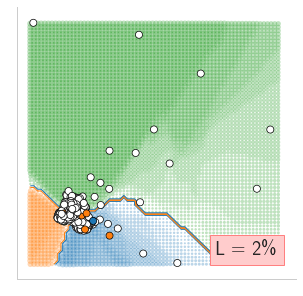

In [64]:
for n_noisy, (x, y) in out.items():
    # load data again

    clf = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
    clf.fit(x, y)
    acc = accuracy_score(y, clf.predict(x))

    # use function
    plot_decision_boundary2D(3,"t-SNE",f"{n_noisy}", str(int(100*(0.999925-acc)/(0.999925-1/3))), clf, x, y.copy(), classes, colormap, 
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,)